In [1]:
!pip install -qq dask

In [70]:
# Importing the required libraries
import os
import numpy as np
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import models
from tensorflow.keras.preprocessing import text
import warnings
warnings.filterwarnings('ignore')
from sklearn import model_selection
from sklearn import metrics

import pandas as pd
import dask.dataframe as dd

In [3]:
# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Reading the DataSet
path = '/content/drive/My Drive/DataSets'

sms = pd.read_csv(os.path.join(path,"spam.csv"), encoding='latin-1')
sms.dropna(how="any", inplace=True, axis="columns")
sms.columns = ['label', 'message']
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Describing the Dataset
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
# Doing some basic exploration
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [7]:
sms['label_num'] = sms.label.map({'ham':0,'spam':1})
sms['message_len'] = sms.message.apply(len)
sms.head()

,label,message,label_num,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


In [8]:
sms.describe()

,label_num,message_len
count,5572.000000,5572.000000
mean,0.134063,80.118808
std,0.340751,59.690841
min,0.000000,2.000000
25%,0.000000,36.000000
50%,0.000000,61.000000
75%,0.000000,121.000000
max,1.000000,910.000000


In [9]:
sms[sms.message_len == 910].message.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [10]:
# Cleaning and doing some preliminary operations
import string
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')

def text_process(mess):
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return  ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])
    # return ' '.join([lemmatizer.lemmatize(word) for word in nopunc.split()])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [11]:
sms['clean_msg'] = sms.message.apply(text_process)

In [12]:
sms.drop(['label','message','message_len'],inplace=True,axis='columns')
sms['message_len'] = sms.clean_msg.apply(len)
sms.head()

,label_num,clean_msg,message_len
0,0,Go jurong point crazy Available bugis n great ...,82
1,0,Ok lar Joking wif oni,21
2,1,Free entry wkly comp win FA Cup final tkts 21s...,133
3,0,dun say early hor c already say,31
4,0,Nah think goes usf lives around though,38


1084    511
2433    425
1862    407
3015    396
1578    378
2157    339
2847    339
5104    330
2369    330
2680    329
Name: message_len, dtype: int64


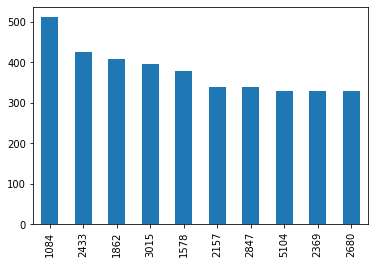

In [13]:
print(sms.message_len.sort_values(ascending=False).head(10))
sms.message_len.sort_values(ascending=False).head(10).plot(kind ='bar')

In [14]:
# separating indipendent and dependent variable
X = sms.clean_msg
y = sms.label_num.values

In [15]:
# Doing one how encoding step required for word embedding
vocab_size = 100000
onehot_repr=[text.one_hot(words,vocab_size)for words in X] 
print(onehot_repr)

[[8058, 25313, 44422, 62051, 5407, 91521, 51350, 3143, 54988, 29994, 75541, 22309, 72963, 10099, 60625, 64162], [21188, 97643, 89604, 65312, 56352], [4649, 87903, 56799, 96081, 48491, 52665, 34595, 19188, 37935, 52090, 39952, 15155, 33594, 52665, 97808, 17607, 87903, 36740, 30782, 36857, 17453, 55927], [43442, 2634, 75187, 50592, 61276, 15111, 2634], [71158, 98385, 70472, 68074, 87856, 30529, 37915], [99378, 96418, 78382, 77503, 99233, 4822, 71924, 43074, 57021, 30916, 29964, 21516, 21188, 5372, 68365, 25037, 83470, 38891, 93013], [92494, 56548, 57021, 29931, 93293, 57021, 83390, 224], [70725, 85008, 47494, 47494, 2595, 48595, 60626, 87047, 71189, 61817, 84732, 82398, 77452, 16933, 63976, 61817], [3025, 19812, 61155, 97608, 80401, 51669, 56518, 66704, 94276, 66944, 1786, 58888, 66944, 4935, 70684, 84782, 29820, 5235], [41439, 598, 3326, 25662, 6349, 50866, 79112, 46859, 15617, 99678, 4649, 1786, 41439, 50866, 85541, 4649, 70512], [19762, 77977, 70462, 53682, 88715, 90492, 92434, 91616,

In [22]:
# Padding the sentence to make it same length
sent_length = 520
embedded_docs=sequence.pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[    0     0     0 ... 10099 60625 64162]
 [    0     0     0 ... 89604 65312 56352]
 [    0     0     0 ... 36857 17453 55927]
 ...
 [    0     0     0 ... 13994 84920 41024]
 [    0     0     0 ...  1931 64053  4649]
 [    0     0     0 ... 57474 20318 58237]]


In [32]:
# Splitting the Data int0 train and test
X_train,X_test,y_train,y_test = model_selection.train_test_split(embedded_docs,y,test_size=0.2,random_state=42)

In [33]:
# Creating a very basic model as the idea for this notebook is to start with  the embedding layer
dim = 50
model=models.Sequential()
model.add(layers.Embedding(vocab_size,dim,input_length=sent_length))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 520, 50)           5000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 26000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                832032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 5,832,065
Trainable params: 5,832,065
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [35]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/10
140/140 [==============================] - 5s 36ms/step - loss: 0.2652 - acc: 0.8988 - val_loss: 0.1516 - val_acc: 0.9641
Epoch 2/10
140/140 [==============================] - 5s 34ms/step - loss: 0.1210 - acc: 0.9809 - val_loss: 0.1275 - val_acc: 0.9803
Epoch 3/10
140/140 [==============================] - 5s 35ms/step - loss: 0.0932 - acc: 0.9939 - val_loss: 0.1390 - val_acc: 0.9740
Epoch 4/10
140/140 [==============================] - 5s 34ms/step - loss: 0.0791 - acc: 0.9969 - val_loss: 0.1243 - val_acc: 0.9794
Epoch 5/10
140/140 [==============================] - 5s 34ms/step - loss: 0.0693 - acc: 0.9991 - val_loss: 0.1097 - val_acc: 0.9857
Epoch 6/10
140/140 [==============================] - 5s 35ms/step - loss: 0.0630 - acc: 0.9996 - val_loss: 0.1304 - val_acc: 0.9785
Epoch 7/10
140/140 [==============================] - 5s 34ms/step - loss: 0.0572 - acc: 1.0000 - val_loss: 0.1235 - val_acc: 0.9794
Epoch 8/10
140/140 [==============================] - 5s 36ms/step - 

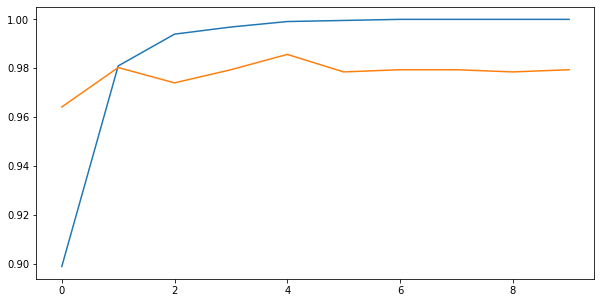

In [46]:
# Plotting the  accuracy for train and test
from matplotlib import pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

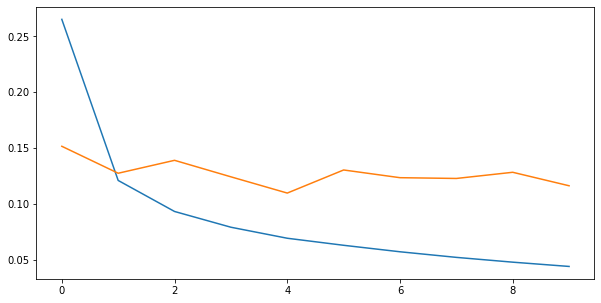

In [47]:
# Plotting the loss for train and test
from matplotlib import pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [99]:
# Using base metrics for the validation
prediction = model.predict(X_test).reshape(-1,)
# prediction = [1 if x>0.5 else 0 for x in prediction]

In [100]:
l1 = [i/100 for i in range(10,110,10)]
for i in l1:
  pred = [1 if x>i else 0 for x in prediction]
  con_mat = metrics.confusion_matrix(y_test,pred)
  print(i,con_mat[1,0])

0.1 12
0.2 17
0.3 18
0.4 20
0.5 23
0.6 23
0.7 26
0.8 150
0.9 150
1.0 150


In [101]:
prediction = [1 if x>0.3 else 0 for x in prediction]
print(metrics.classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       1.00      0.88      0.94       150

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [102]:
metrics.confusion_matrix(y_test,prediction)

array([[965,   0],
       [ 18, 132]])